# **Import Libraries**

In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import os
from tqdm import tqdm

from google.colab import drive
drive.mount("/content/drive")

# **Model Structure**

**vocab_size:**      size of the dictionary of embeddings

**embd_dim:**        the size of each embedding vector

**n_hidden:**        Hidden layer dimension

**n_layers:**        Number of layers

**dropout:**         dropout value, '0' if no dropout

**is_lstm:**          TRUE if LSTM based, FALSE for GRU based

In [ ]:
class NextWordPredict(nn.Module):
      def __init__(self, vocab_size, embd_dim, n_hidden, n_layers, dropout=0, is_lstm=True):
        super().__init__()
        # save init values
        self.vocab_size = vocab_size
        self.embd_dim = embd_dim
        self.n_hidden = n_hidden
        self.n_layers = n_layers


        # define the model
        self.rnn = nn.LSTM(embd_dim, n_hidden, n_layers, dropout=dropout) if is_lstm else nn.GRU(embd_dim, n_hidden, n_layers, dropout=dropout) # Will be define by each model type (LSTM/GRU)
        self.embd = nn.Embedding(vocab_size, embd_dim)
        self.drop = nn.Dropout(dropout) if dropout else None
        self.fc = nn.Linear(n_hidden, vocab_size)

      def forward(self, input):
        out = self.embd(input)
        out, hidden = self.rnn(out)
        # Be aware that the dropout is taking place inside the RNN!
        out = self.fc(out)
        return out



# **Load Data**

**path:** data path

**seq_len:** sequence length

**vocab:** optional predefined vocabulary

In [ ]:
class PTBDataset(Dataset):
    def __init__(self, path, seq_len, vocab=None):
        # Tokenize the text (simple space-based tokenization)
        with open(path) as f:
            text = f.read()
        self.tokens = text.split()
        self.seq_len = seq_len

        # Build vocabulary if not provided
        if vocab is None:
            self.vocab = self.build_vocab(self.tokens)
        else:
            self.vocab = vocab

        self.vocab_size = len(self.vocab)
        # Convert tokens to indices
        self.token_indices = [self.vocab.get(token, '<unk>') for token in self.tokens]

    def build_vocab(self, tokens):
        # Count the tokens and add <unk> for unknown tokens
        vocab = {'<unk>': 0}
        token_counts = Counter(tokens)
        token_counts.pop('<unk>', None)
        vocab.update({token: idx + 1 for idx, (token, _) in enumerate(token_counts.items())})
        return vocab

    def __len__(self):
        # Return the number of tokens (minus one since we predict the next token)
        return len(self.tokens) - (1 + self.seq_len)

    def __getitem__(self, idx):
        # Return the current token and the next token (as indices)
        current_token_idx = self.token_indices[idx:self.seq_len+idx]
        # next_token_idx = self.token_indices[idx+1:self.seq_len+idx+1]  if want labels to be all the sequence with offset 1
        next_token_idx = self.token_indices[self.seq_len+idx+1]
        return torch.tensor(current_token_idx), torch.nn.functional.one_hot(torch.tensor(next_token_idx), self.vocab_size).type(torch.float)

# **Data Location**

In [ ]:
base_path = '/content/drive/MyDrive/ex2_313135261_208678827/PTB/'
train_path = os.path.join(base_path, 'ptb.train.txt')
valid_path = os.path.join(base_path, 'ptb.valid.txt')
test_path = os.path.join(base_path, 'ptb.test.txt')

# **Functions Definition**

In [ ]:
# Save the current trained model
def save_model(model, save_path):
  torch.save(model.state_dict(),save_path, )

# Load Pre-trained model
def load_model(model, path):
  sd = torch.load(path)
  model.load_state_dict(sd)

# Define function to calculate perplexity
def calculate_perplexity(loss):
    return 2 ** loss

# Plot graph
def plot(train_perps, val_perps, test_perps, model_name):
      # Plot convergence graphs (modify as needed for multiple lines)
      plt.figure(figsize=(10, 6))
      plt.axhline(y = test_perps, color = 'r', linestyle = 'dashed', label="Test")
      plt.plot(train_perps, label="Train")
      plt.plot(val_perps, label="Validation")
      plt.xlabel("Epoch")
      plt.ylabel("Perplexity")
      plt.title(f"{model_name} Perplexity Convergence")
      plt.legend()
      plt.grid(True)
      plt.savefig(f"{model_name}_perplexity.png")
      plt.show()
      plt.close()

# **Model Parameters**
### **Instructions:**
*   **LSTM or GRU:**
in case of model training, set "is_lstm" to TRUE if the network is based on LSTM, and FALSE if it based on GRU.

*   **Pre-trained model:** in case of using pre-trained model, set "load_pretrained" to TRUE, else FALSE

*   **Dropout:** if using dropout - set "dropout" to the desired value, if not using dropout - set to '0'
*   List item





In [ ]:
# Set params
embd_dim = 128
n_hidden = 200
n_layers = 2
seq_len = 20
learning_rate = 0.001
dropout = 0
batch_size = 128
is_lstm = True

# Process Data
train_data = PTBDataset(train_path, seq_len)
valid_data = PTBDataset(valid_path, seq_len, train_data.vocab)
test_data = PTBDataset(test_path, seq_len, train_data.vocab)

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

vocab_size = len(train_data.vocab)

# Set the model
model = NextWordPredict(vocab_size, embd_dim, n_hidden, n_layers, dropout=dropout, is_lstm=is_lstm)

# Set criterion
criterion = nn.CrossEntropyLoss()

# Check if GPU is available or not
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# **Training Structure**

In [ ]:
def train(model, epochs, device, train_dataloader, valid_dataloader, learning_rate):
    model.train()
    model.to(device)
    # Set optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_perplexity = []
    valid_perplexity = []
    test_perplexity = []
    epochs_perp = []
    val_perps = []
    losses = []
    for epoch in range(epochs):
      epoch_loss = []
      for inputs, targets in tqdm(train_dataloader) :
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        preds = preds[:, -1, :]
        loss = criterion(preds, targets)
        loss.backward()
        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss.append(loss.item())
        losses.append(loss.item())

      # Calculate loss
      total_epoch_loss = np.mean(epoch_loss)
      train_epoch_perp = calculate_perplexity(total_epoch_loss)
      epochs_perp.append(train_epoch_perp)

      valid_perp = evaluate(model, valid_dataloader, device, criterion)
      val_perps.append(valid_perp)

      # Print and store epoch results
      print(f"Epoch {epoch+1}: Train Perplexity = {train_epoch_perp:.4f}, Val Perplexity = {valid_perp:.4f}")
    return epochs_perp, val_perps

# **Evaluate Structure**

In [ ]:
def evaluate(model, dataloader, device, criterion):
    model.eval()
    loss = []
    perplexity = []
    for inputs, targets in tqdm(dataloader):
      # turn off gradients
      with torch.no_grad():
        # set model to evaluation mode
        inputs, targets = inputs.to(device), targets.to(device)
        preds = model(inputs)
        preds = preds[:,-1,:]
        loss.append(criterion(preds, targets).item())

    model.train()

    # calculate perplexity
    total_loss = np.mean(loss)

    # return total_loss
    return calculate_perplexity(total_loss)

# **Training the model**

## **LSTM with Dropout - Training**

100%|██████████| 550/550 [00:08<00:00, 63.24it/s]


Epoch 1: Train Perplexity = 93.0592, Val Perplexity = 86.1445


100%|██████████| 550/550 [00:08<00:00, 64.06it/s]


Epoch 2: Train Perplexity = 81.0299, Val Perplexity = 82.5250


100%|██████████| 550/550 [00:08<00:00, 63.60it/s]


Epoch 3: Train Perplexity = 75.6133, Val Perplexity = 81.7869


100%|██████████| 550/550 [00:08<00:00, 63.41it/s]


Epoch 4: Train Perplexity = 71.6358, Val Perplexity = 82.1425


100%|██████████| 550/550 [00:08<00:00, 64.37it/s]


Epoch 5: Train Perplexity = 68.3406, Val Perplexity = 83.6391


100%|██████████| 550/550 [00:08<00:00, 64.16it/s]


Epoch 6: Train Perplexity = 65.4640, Val Perplexity = 85.5368


100%|██████████| 550/550 [00:08<00:00, 64.63it/s]


Epoch 7: Train Perplexity = 62.8612, Val Perplexity = 88.5461


100%|██████████| 615/615 [00:09<00:00, 64.59it/s]


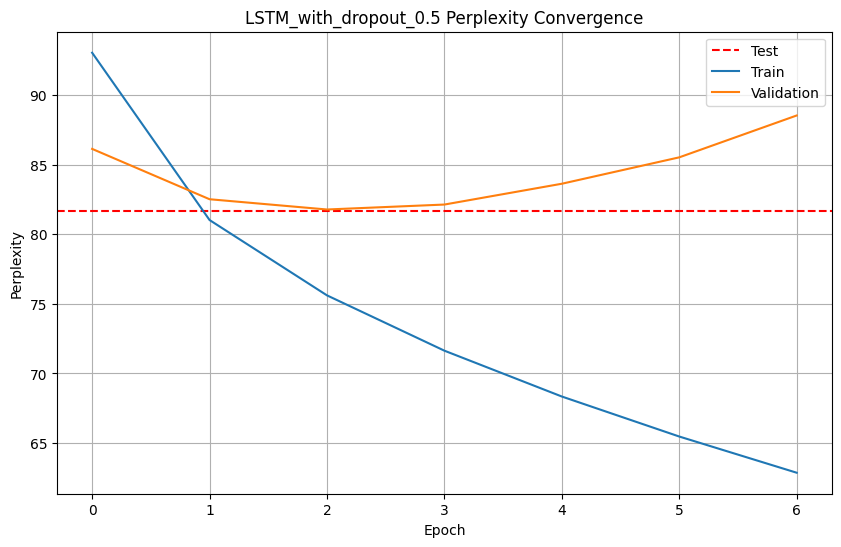

In [ ]:
# Define model
LSTM_with_dropout_model = NextWordPredict(vocab_size, embd_dim, n_hidden, n_layers, dropout=0.5, is_lstm=True)
LSTM_with_dropout_train_perps, LSTM_with_dropout_val_perps = train(LSTM_with_dropout_model, 7, device, train_dataloader, valid_dataloader, learning_rate)

model_name = 'LSTM_with_dropout_0.5'
saved_models_path = '/content/drive/MyDrive/ex2_313135261_208678827/'
save_model(LSTM_with_dropout_model, os.path.join(saved_models_path,f'model_{model_name}.pt'))

# Test and plot
test_perps = evaluate(LSTM_with_dropout_model, test_dataloader, device, criterion)
plot(LSTM_with_dropout_train_perps, LSTM_with_dropout_val_perps, test_perps, model_name)

## **LSTM without Dropout - Training**

100%|██████████| 550/550 [00:08<00:00, 65.02it/s]


Epoch 1: Train Perplexity = 93.9527, Val Perplexity = 86.3682


100%|██████████| 550/550 [00:08<00:00, 64.77it/s]


Epoch 2: Train Perplexity = 82.4931, Val Perplexity = 83.3152


100%|██████████| 550/550 [00:08<00:00, 63.99it/s]


Epoch 3: Train Perplexity = 77.7425, Val Perplexity = 82.5534


100%|██████████| 550/550 [00:08<00:00, 63.16it/s]


Epoch 4: Train Perplexity = 74.5266, Val Perplexity = 82.6056


100%|██████████| 550/550 [00:08<00:00, 65.41it/s]


Epoch 5: Train Perplexity = 71.9754, Val Perplexity = 83.3740


100%|██████████| 550/550 [00:08<00:00, 64.04it/s]


Epoch 6: Train Perplexity = 69.9950, Val Perplexity = 83.9316


100%|██████████| 550/550 [00:08<00:00, 64.64it/s]


Epoch 7: Train Perplexity = 68.3605, Val Perplexity = 84.9166


100%|██████████| 615/615 [00:09<00:00, 64.89it/s]


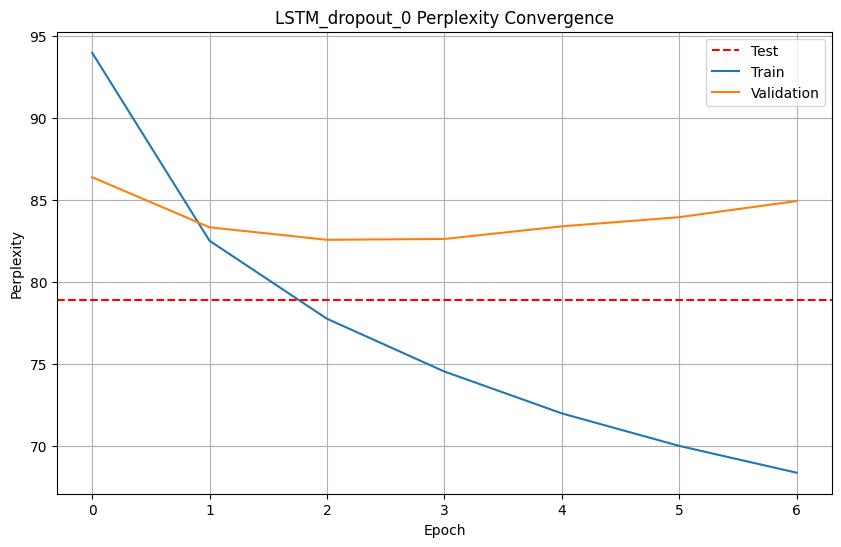

In [ ]:
# Define model
LSTM_no_dropout_model = NextWordPredict(vocab_size, embd_dim, n_hidden, n_layers, dropout=0, is_lstm=True)
LSTM_no_dropout_train_perps, LSTM_no_dropout_val_perps = train(LSTM_no_dropout_model, 7, device, train_dataloader, valid_dataloader, learning_rate)

model_name = 'LSTM_dropout_0'
saved_models_path = '/content/drive/MyDrive/ex2_313135261_208678827/'
save_model(LSTM_no_dropout_model, os.path.join(saved_models_path,f'model_{model_name}.pt'))

# Test and plot
test_perps = evaluate(LSTM_no_dropout_model, test_dataloader, device, criterion)
plot(LSTM_no_dropout_train_perps, LSTM_no_dropout_val_perps, test_perps, model_name)

## **GRU without Dropout - Training**

100%|██████████| 550/550 [00:08<00:00, 65.70it/s]


Epoch 1: Train Perplexity = 99.9244, Val Perplexity = 87.7678


100%|██████████| 550/550 [00:08<00:00, 65.51it/s]


Epoch 2: Train Perplexity = 82.2895, Val Perplexity = 83.1739


100%|██████████| 550/550 [00:08<00:00, 64.68it/s]


Epoch 3: Train Perplexity = 75.7257, Val Perplexity = 82.3335


100%|██████████| 550/550 [00:08<00:00, 65.66it/s]


Epoch 4: Train Perplexity = 71.8116, Val Perplexity = 82.7151


100%|██████████| 550/550 [00:08<00:00, 64.70it/s]


Epoch 5: Train Perplexity = 69.0297, Val Perplexity = 83.0762


100%|██████████| 550/550 [00:08<00:00, 65.41it/s]


Epoch 6: Train Perplexity = 66.9703, Val Perplexity = 83.6068


100%|██████████| 550/550 [00:08<00:00, 64.94it/s]


Epoch 7: Train Perplexity = 65.3495, Val Perplexity = 84.3590


100%|██████████| 615/615 [00:09<00:00, 65.18it/s]


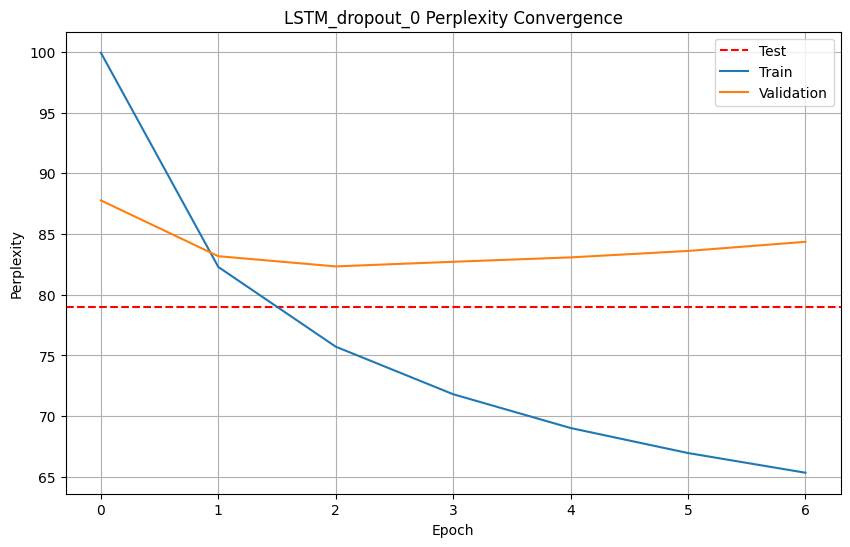

In [ ]:
GRU_no_dropout_model = NextWordPredict(vocab_size, embd_dim, n_hidden, n_layers, dropout=0, is_lstm=False)
GRU_no_dropout_train_perps, GRU_no_dropout_val_perps = train(GRU_no_dropout_model, 7, device, train_dataloader, valid_dataloader, learning_rate)
lstm_or_gru = 'LSTM' if is_lstm else 'GRU'
model_name = f'{lstm_or_gru}_dropout_{dropout}'
saved_models_path = '/content/drive/MyDrive/ex2_313135261_208678827/'
save_model(model, os.path.join(saved_models_path,f'model_{model_name}.pt'))
test_perps = evaluate(GRU_no_dropout_model, test_dataloader, device, criterion)
plot(GRU_no_dropout_train_perps, GRU_no_dropout_val_perps, test_perps, model_name)

100%|██████████| 615/615 [00:09<00:00, 65.34it/s]


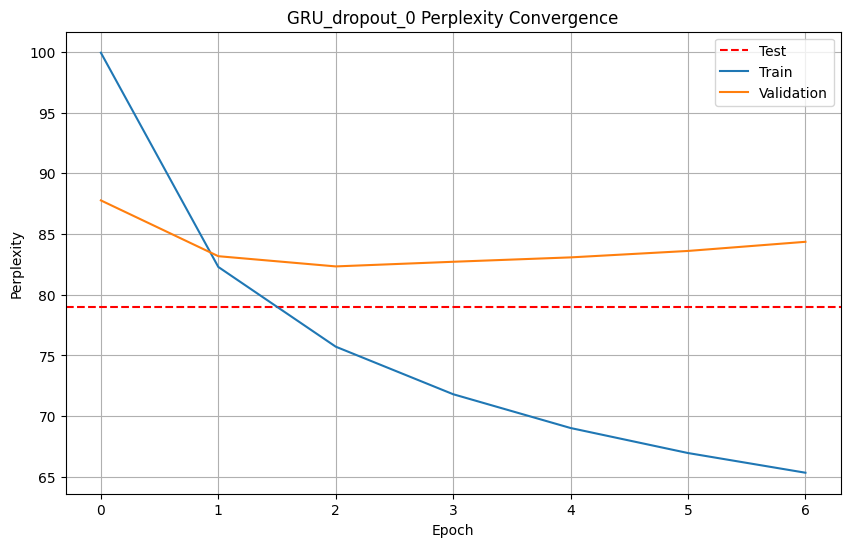

In [ ]:
model_name = 'GRU_dropout_0'
saved_models_path = '/content/drive/MyDrive/ex2_313135261_208678827/'
save_model(model, os.path.join(saved_models_path,f'model_{model_name}.pt'))
test_perps = evaluate(GRU_no_dropout_model, test_dataloader, device, criterion)
plot(GRU_no_dropout_train_perps, GRU_no_dropout_val_perps, test_perps, model_name)

## **GRU with Dropout - Training**

100%|██████████| 550/550 [00:08<00:00, 65.51it/s]


Epoch 1: Train Perplexity = 99.1877, Val Perplexity = 89.2393


100%|██████████| 550/550 [00:08<00:00, 64.07it/s]


Epoch 2: Train Perplexity = 86.1508, Val Perplexity = 86.3589


100%|██████████| 550/550 [00:08<00:00, 65.60it/s]


Epoch 3: Train Perplexity = 82.0305, Val Perplexity = 84.9476


100%|██████████| 550/550 [00:08<00:00, 64.72it/s]


Epoch 4: Train Perplexity = 79.3644, Val Perplexity = 84.6562


100%|██████████| 550/550 [00:08<00:00, 65.67it/s]


Epoch 5: Train Perplexity = 77.5299, Val Perplexity = 84.2727


100%|██████████| 550/550 [00:08<00:00, 64.45it/s]


Epoch 6: Train Perplexity = 76.1774, Val Perplexity = 84.4639


100%|██████████| 550/550 [00:08<00:00, 63.90it/s]


Epoch 7: Train Perplexity = 75.0906, Val Perplexity = 84.7690


100%|██████████| 615/615 [00:09<00:00, 65.11it/s]


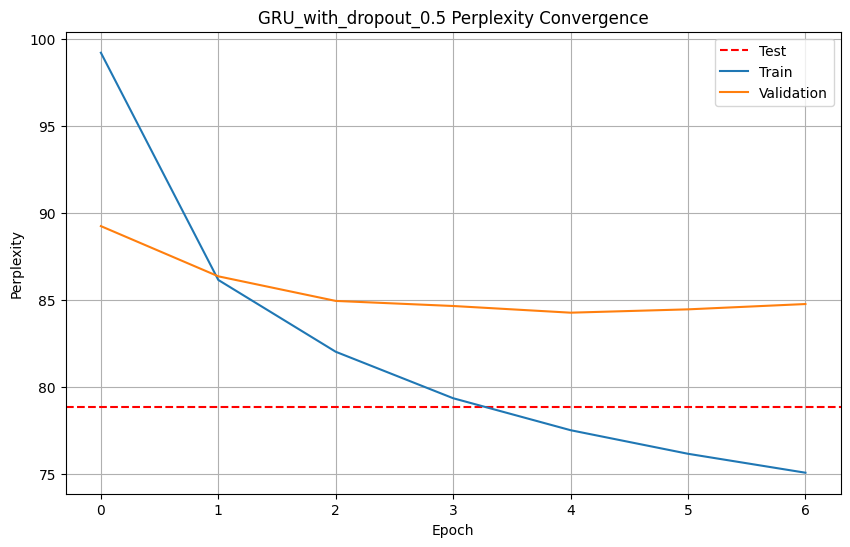

In [ ]:
GRU_with_dropout_model = NextWordPredict(vocab_size, embd_dim, n_hidden, n_layers, dropout=0.5, is_lstm=False)
GRU_with_dropout_train_perps, GRU_with_dropout_val_perps = train(GRU_with_dropout_model, 7, device, train_dataloader, valid_dataloader, learning_rate)
model_name = 'GRU_with_dropout_0.5'
saved_models_path = '/content/drive/MyDrive/ex2_313135261_208678827/'
save_model(model, os.path.join(saved_models_path,f'model_{model_name}.pt'))
test_perps = evaluate(GRU_with_dropout_model, test_dataloader, device, criterion)
plot(GRU_with_dropout_train_perps, GRU_with_dropout_val_perps, test_perps, model_name)

## **Run Pre-Trained Models**

To load a pre-trained model:
1. change the model_base_path to the relevant model.
2. Run cells: "Import Libraries", "Model Structure", "Load Data", "Data location", "Functions Definition", "Model Params", "Training Structure", "Evaluate Structure"
3. Run the cell "Load and Run Pretrained Model"

In [ ]:
model_base_path = '/content/drive/MyDrive/ex2_313135261_208678827/'
model_path = os.path.join(model_base_path, 'model_LSTM_dropout_0.pt')
model = NextWordPredict(vocab_size, embd_dim, n_hidden, n_layers, dropout=0, is_lstm=True)
model(model, device, model_path)
test_perps = evaluate(model, test_dataloader, device, criterion)
print('\nTest Results:', test_perps)